<a href="https://colab.research.google.com/github/raeubaen/giagu/blob/master/NB_randomforest_ising2D_LC1_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione stato di un modello di Ising 2D con Random Forests

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Informazioni ###

scopo: imparare ad usare ensamble di modelli deboli tipo foreste random di alberi a decisione binaria 
applicazione: classificazione dello fase in cui si trovano configurazioni di un modello di Ising 2D <br>
ML tool: scikit-learn


### Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È definito su un reticolo bidimensionale dall'Hamiltoniana 

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si dimostra che questo sistema presenta una transizione di fase nel limite termodinamico da un sistea ordinato con tutti gli spin allineati (ferromagnete ordinato) a una fase disordinata con spin random, alla temperatura critica $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$. 


**Dataset:**

100k configurazioni con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis. 

Il campione è disponibile qui:

* [configurazioni](https://www.dropbox.com/s/ma1n1r2uejb9iei/ising_conf.dat?dl=0)
* [label](https://www.dropbox.com/s/dj1urxh8tsadoh5/ising_label.dat?dl=0)

NOTA: le configurazioni sono 28x28 valori dello spin, le label sono la temperatura associata ad ogni configurazione.

Poiché è noto che vicino alla temepratura critica $T_c$, la lunghezza delle correlazioni ferromagnetiche diverge, rendendo difficile identificare la fase, dvideremo il campione in tre sotto-campioni:

* ordinato: $T/J<2.0$
* critico: $2.0\leq T/J\leq 2.5$
* disordinato: $T/J>2.5$

e addestreremo il modello usando solo le configurazioni ordinate e disordinate. Poi testeremo il tutto su tutte le configurazioni.

### Parte 1: load e pre-processamento del dataset ###

In [0]:
import numpy as np

np.random.seed() # shuffle random seed generator

# Ising model parameters
L = 28 # size del reticolo
J = 1.0 # Ising interaction (1 ferromagnetico, -1 anti-ferromagnetico)
T_c = 2.26 # Temperatura critica

In [3]:
#leggiamo le configurazioni ising dal file usando numpy (100k esempi oguno da 28x28 spin)
data = np.loadtxt('/content/drive/My Drive/Colab Notebooks/dataset/ising_conf.dat')
print(data.shape)

(2800000, 28)


NOTA: gli esempi sono scritti nel file come righe sequenziali da 28 valori l'una -> 100k x 28 = 2800000 

In [4]:
# al fine di visualizzare alcune delle configurazioni convertiamo il vettore numpy 
# in un tensore di 100K eventi ognuno 
# formato da una matrice 28x28 di spin
data = data.reshape(100000,28,28)
print(f"Data shape: {data.shape}")
conf_num = data.shape[0]

Data shape: (100000, 28, 28)


In [5]:
#esempio
import pandas as pd
rnd = np.random.randint(0, conf_num)
#stampa un evento come una matrice 28x28 di valori dello spin (-1,1)
print(pd.DataFrame(data[rnd]))

     0    1    2    3    4    5    6   ...   21   22   23   24   25   26   27
0   1.0  1.0  1.0  1.0 -1.0  1.0 -1.0  ...  1.0 -1.0  1.0 -1.0  1.0  1.0  1.0
1   1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0  1.0  1.0  1.0
2   1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0  1.0  1.0  1.0
3  -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
4  -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
5  -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
6  -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
7  -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
8  -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
9  -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
10 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
11 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -

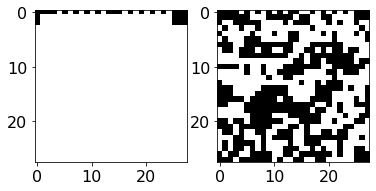

In [6]:
# plotta come un immagine la matrice precedente e quella successiva nell'array
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_conf(axarr, data_list, titles_list):
  cmap_args=dict(cmap='binary')
  for i in range(len(data_list)):
    axarr[i].imshow(data_list[i], **cmap_args)
    axarr[i].set_title(titles_list[i], fontsize=16)
    axarr[i].tick_params(labelsize=16)

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=2)
plot_conf(axarr, [data[rnd], data[rnd+1]], ["", ""])
plt.show()


In [7]:
#leggiamo da file le label associate:
labels = np.loadtxt('/content/drive/My Drive/Colab Notebooks/dataset/ising_label.dat')
print(labels.shape)
print(f"T/J: {labels[rnd]}") #T/J della configurazione dell'evento mostrato prima

(100000,)
T/J: 0.598771


In [8]:
# dividiamo il campione in 3 campioni sulla base dello stato (ordinato, critico, disordinato)
# T/J < 2.0 ordinato
# T/J > 2.5 disordinato
# altrimenti critico

ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))
    
data_ord, n_ord = data[ord_sele], np.sum(ord_sele)
data_dis, n_dis = data[dis_sele], np.sum(dis_sele)
data_cri, n_cri = data[cri_sele], np.sum(cri_sele)

print(f"Number of ordered configurations:\t{n_ord}") 
print(f"Number of disordered configurations:\t{n_dis}") 
print(f"Number of critical configurations:\t{n_cri}") 

labels_ord = np.zeros(data_ord.shape[0])
labels_dis = np.ones(data_dis.shape[0])
labels_critic = labels[cri_sele]

labels_cri = labels_critic.copy()
labels_cri[labels_critic>T_c] = 1
labels_cri[labels_critic<=T_c] = 0

print(f"Ordered Conf. labels:\t\t\t{labels_ord}")
print(f"Disordered Conf. labels:\t\t{labels_dis}")
print(f"Critical Conf. labels:\t\t\t{labels_cri}")

Number of ordered configurations:	40177
Number of disordered configurations:	50015
Number of critical configurations:	9808
Ordered Conf. labels:			[0. 0. 0. ... 0. 0. 0.]
Disordered Conf. labels:		[1. 1. 1. ... 1. 1. 1.]
Critical Conf. labels:			[1. 0. 0. ... 1. 0. 1.]


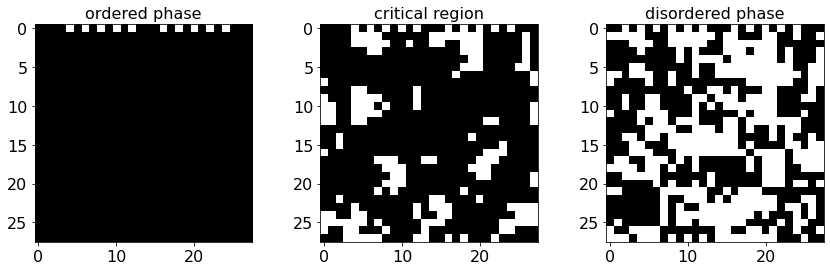

In [9]:
#una rappresentazione grafica più bella
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

plot_conf(
    axarr, 
    [data_ord[4], data_cri[4], data_dis[4]], 
    ['ordered phase', 'critical region', 'disordered phase'],
)

fig.subplots_adjust(right=2.0)
plt.show()

In [10]:
##Dividiamo il campione per il training
from sklearn.model_selection import train_test_split

train_to_test_ratio = 0.8 # training samples

# define training and test data sets
X = np.concatenate((data_ord,data_dis))
Y = np.concatenate((labels_ord,labels_dis))

# selezioniamo random data points dai campioni ordinati e disordinati per cerare training e test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    train_size=train_to_test_ratio,
    test_size=1.0 - train_to_test_ratio
)

X_critical = data_cri
Y_critical = labels_cri

print('X_train shape:', X_train.shape)
print(f'Y_train shape: {Y_train.shape}\n')
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

# riformattiamo i tensori in modo che abbiano l'input corretto atteso dagli alberi a decisione binaria 
# (vettori flat di features)   (N,28,28) -> (N, 28*28 = 784)

X_train = np.reshape(X_train, (X_train.shape[0], 28*28))
X_test = np.reshape(X_test, (X_test.shape[0], 28*28))
X_critical = np.reshape(X_critical, (X_critical.shape[0], 28*28))

X_train shape: (72153, 28, 28)
Y_train shape: (72153,)

72153 train samples
9808 critical samples
18039 test samples


### Parte 2: addestramento della Random Forests

**Iperparametri**

Usiamo l'implementazione in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) che ha due iperparamteri principali che possono modificare anche sensibimente le prestazioni del modello e il livelo di overfit/underfit: il numero di alberi nella foresta e la complessità di ciascun albero: il primo è controllato dal parametro `n_estimators`, mentre la complesiità è controllata da vari parametri `min_samples_split`, `min_samples_leaf`, `min_impurity_decrease`, etc, in parte correlati tra loro. Nell'esempio in esame per semplicità useremo solo `min_samples_split` (governa il numero di campioni necessari per procedere ad uno split di un nodo: più alto è il numero minore sarà la segmentazione e le diramazioni dell'albero.

**NOTA: Stime OOB (Out of Bag)**

È un metodo molto utile per ottimizzare gli iperparametri quando si usano metodi di bagging: consiste nel verificare quanto bene funziona il classificatore su quegli eventi del training set che non sono stati usati nel training (perchè non campionati nella technica di boostrap). Gioca un ruolo simile alla k-fold cross-validation.

In [11]:
# Scikit-learn Random Forest
from sklearn.ensemble import RandomForestClassifier
import time
import warnings
#disabilitiamo messaggi di warning 
warnings.filterwarnings("ignore")

#Valore del numero di alberi 
min_estimators = 10
max_estimators = 101
classifer = RandomForestClassifier

#testiamo 10 valori per il primo iperparametro
n_estimator_range = np.arange(min_estimators, max_estimators, 10) 

#testiamo due valori per il seocondo iperparametro 
# (alta segmentazione e bassa segmentazione)
leaf_size_list = [2, 10000] 

m = len(n_estimator_range)
n = len(leaf_size_list)

#Allocate Arrays for various quantities
RFC_OOB_accuracy = np.zeros((n, m))
RFC_train_accuracy = np.zeros((n, m))
RFC_test_accuracy = np.zeros((n, m))
RFC_critical_accuracy = np.zeros((n, m))
run_time = np.zeros((n, m))

print_flag = True

for i, leaf_size in enumerate(leaf_size_list):
    # Define Random Forest Classifier
    myRF_clf = classifer(
        n_estimators=min_estimators,
        max_depth=None, 
        min_samples_split=leaf_size, # minimum number of sample per leaf
        oob_score=True,
        random_state=0,
        warm_start=True 
        # When set to True, reuses the solution of the previous call to fit and 
        # adds more estimators to the ensemble, otherwise, just fits a whole new forest.
    )

    for j, n_estimator in enumerate(n_estimator_range):
        
        print('n_estimators: %i, leaf_size: %i'%(n_estimator, leaf_size))
        
        start_time = time.time()
        myRF_clf.set_params(n_estimators=n_estimator)
        myRF_clf.fit(X_train, Y_train)
        run_time[i,j] = time.time() - start_time

    # check accuracy
        RFC_train_accuracy[i,j]=myRF_clf.score(X_train, Y_train)
        RFC_OOB_accuracy[i,j]=myRF_clf.oob_score_
        RFC_test_accuracy[i,j]=myRF_clf.score(X_test, Y_test)
        RFC_critical_accuracy[i,j]=myRF_clf.score(X_critical, Y_critical)
        if print_flag:
            result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_OOB_accuracy[i,j], RFC_test_accuracy[i,j], RFC_critical_accuracy[i,j])
            print('{0:<15}{1:<15}{2:<15}{3:<15}{4:<15}'.format("time (s)","train score", "OOB estimate","test score", "critical score"))
            print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}{4:<15.4f}'.format(*result))


n_estimators: 10, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
3.7636         1.0000         0.9919         0.9996         0.8065         
n_estimators: 20, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
3.9833         1.0000         0.9995         0.9997         0.8136         
n_estimators: 30, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
6.6394         1.0000         0.9997         0.9998         0.8171         
n_estimators: 40, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
5.1004         1.0000         0.9998         0.9998         0.8184         
n_estimators: 50, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
4.9063         1.0000         0.9997         0.9998         0.8192         
n_estimators: 60, leaf_size: 2
time (s)       train score    OOB estimate   test scor

**Grafico delle prestazioni:**

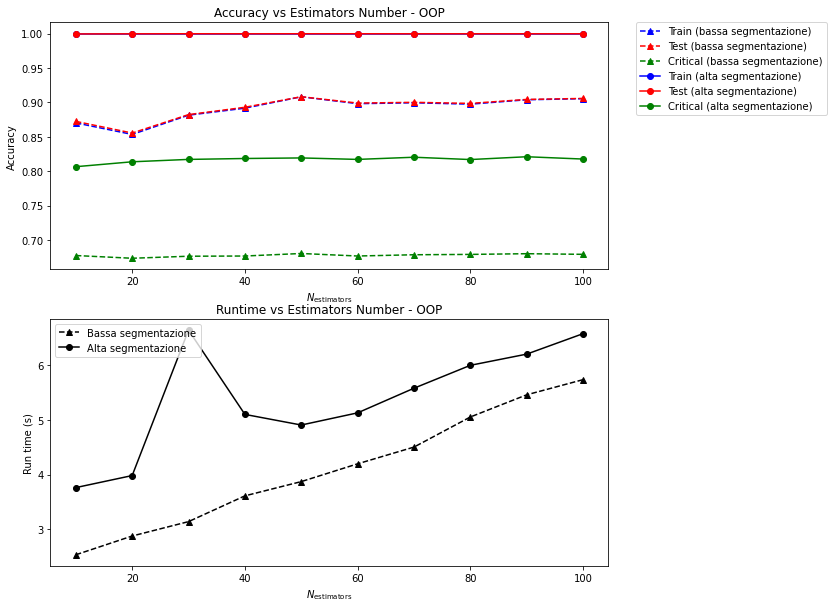

In [12]:
def plot_performance(RFC_train_accuracy, RFC_test_accuracy, RFC_critical_accuracy):
    fig, axs = plt.subplots(2, figsize=(10, 10))
    ax0 = axs[0]
    ax0.plot(n_estimator_range,RFC_train_accuracy[1],'--b^',label='Train (bassa segmentazione)')
    ax0.plot(n_estimator_range,RFC_test_accuracy[1],'--r^',label='Test (bassa segmentazione)')
    ax0.plot(n_estimator_range,RFC_critical_accuracy[1],'--g^',label='Critical (bassa segmentazione)')

    ax0.plot(n_estimator_range,RFC_train_accuracy[0],'o-b',label='Train (alta segmentazione)')
    ax0.plot(n_estimator_range,RFC_test_accuracy[0],'o-r',label='Test (alta segmentazione)')
    ax0.plot(n_estimator_range,RFC_critical_accuracy[0],'o-g',label='Critical (alta segmentazione)')

    ax0.set(xlabel='$N_\mathrm{estimators}$', ylabel='Accuracy')
    lgd = ax0.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    ax1 = axs[1]
    ax1.plot(n_estimator_range, run_time[1], '--k^',label='Bassa segmentazione')
    ax1.plot(n_estimator_range, run_time[0], 'o-k',label='Alta segmentazione')
    ax1.set(xlabel='$N_\mathrm{estimators}$', ylabel='Run time (s)')

    ax1.legend(loc=2)
    #plt.savefig("Ising_RF_Runtime.pdf")
    return (fig, axs)

fig, axs = plot_performance(RFC_train_accuracy, RFC_test_accuracy, RFC_critical_accuracy)
axs[0].set(title="Accuracy vs Estimators Number - OOP")
axs[1].set(title="Runtime vs Estimators Number - OOP")
plt.show()

### Esercizi: ###  

* provate a implementare invece che una validazione OOB (gratis con le foreste random in scikit-learn) una k-fold validation (con k=5 e 10) e verificate se vi sono differenze (OOB tende a dare delle stime molto pessimistiche).
    
NOTA: per imparare ad implementare una k-fold validation in scikit-learn guardate a questo [tutorial](https://scikit-learn.org/stable/modules/cross_validation.html)

In [13]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
RFC_cv_accuracy = np.zeros((n, m))
n_folds = 5

def train_with_k_folds(n_folds):
    for i, leaf_size in enumerate(leaf_size_list):
        myRF_clf = classifer(
                n_estimators=min_estimators,
                max_depth=None, 
                min_samples_split=leaf_size, # minimum number of sample per leaf
                oob_score=False, #now we use k-fold CV
                random_state=0,
                warm_start=True 
                # When set to True, reuses the solution of the previous call to fit and 
                # adds more estimators to the ensemble, otherwise, just fits a whole new forest.
            )
        for j, n_estimator in enumerate(n_estimator_range):
            
            print('n_estimators: %i, leaf_size: %i'%(n_estimator, leaf_size))
                # Define Random Forest Classifier
            myRF_clf.set_params(n_estimators=n_estimator)
            # StratifiedKFold preserves proportion between labels in every k-fold
            skf = StratifiedKFold(n_splits=n_folds) 
            scores = []

            start_time = time.time()
            for train_index, test_index in skf.split(X_train, Y_train):
                X_cv_train, X_cv_test = X_train[train_index], X_train[test_index]
                Y_cv_train, Y_cv_test = Y_train[train_index], Y_train[test_index]
                myRF_clf.fit(X_cv_train, Y_cv_train)
                scores.append(myRF_clf.score(X_cv_test, Y_cv_test))
            run_time[i,j] = time.time() - start_time

        # check accuracy
            RFC_train_accuracy[i,j] = myRF_clf.score(X_train, Y_train)
            RFC_cv_accuracy[i,j] = np.array(scores).mean()
            RFC_test_accuracy[i,j] = myRF_clf.score(X_test, Y_test)
            RFC_critical_accuracy[i,j] = myRF_clf.score(X_critical, Y_critical)
            if print_flag:
                result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_cv_accuracy[i,j], RFC_test_accuracy[i,j], RFC_critical_accuracy[i,j])
                print('{0:<15}{1:<15}{2:<15}{3:<15}{4:<15}'.format("time (s)","train score", "CV score","test score", "critical score"))
                print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}{4:<15.4f}'.format(*result))
    return (RFC_train_accuracy, RFC_cv_accuracy, RFC_test_accuracy, RFC_critical_accuracy)

RFC_train_acc, RFC_cv_acc, RFC_test_acc, RFC_critical_acc = train_with_k_folds(5)

n_estimators: 10, leaf_size: 2
time (s)       train score    CV score       test score     critical score 
4.5764         0.9998         0.9998         0.9996         0.8051         
n_estimators: 20, leaf_size: 2
time (s)       train score    CV score       test score     critical score 
4.5298         0.9999         0.9999         0.9998         0.8097         
n_estimators: 30, leaf_size: 2
time (s)       train score    CV score       test score     critical score 
4.3465         0.9999         0.9999         0.9998         0.8136         
n_estimators: 40, leaf_size: 2
time (s)       train score    CV score       test score     critical score 
4.8102         0.9999         0.9999         0.9998         0.8160         
n_estimators: 50, leaf_size: 2
time (s)       train score    CV score       test score     critical score 
4.7053         0.9999         0.9999         0.9998         0.8106         
n_estimators: 60, leaf_size: 2
time (s)       train score    CV score       test scor

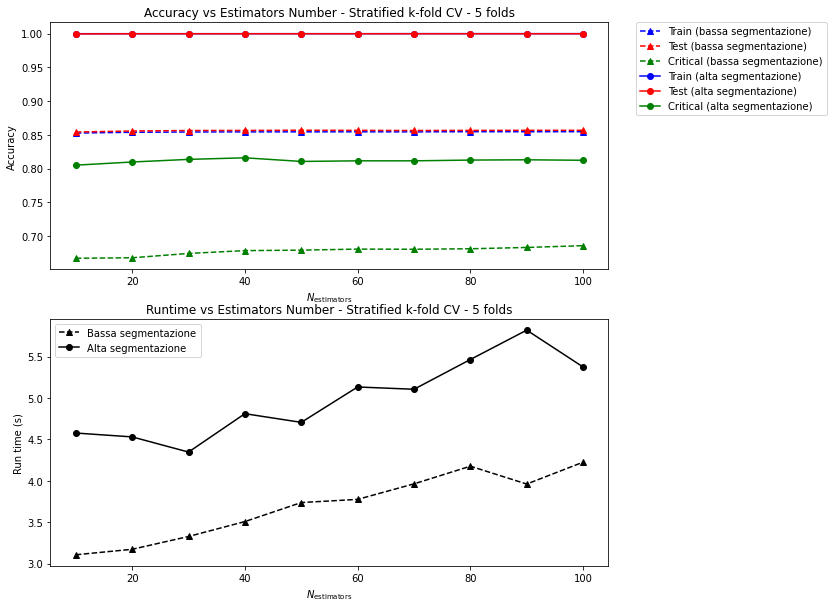

In [14]:
fig, axs = plot_performance(RFC_train_accuracy, RFC_test_accuracy, RFC_critical_accuracy)
axs[0].set(title="Accuracy vs Estimators Number - Stratified k-fold CV - 5 folds")
axs[1].set(title="Runtime vs Estimators Number - Stratified k-fold CV - 5 folds")
plt.show()

Grazie al processo di media tra gli scores delle singole validazioni e grazie al fatto che, essendo il dataset in questione essenzialmente stocastico, i sottogruppi estratti con la stratified k-fold cross validation sono abbastanza indipendenti ed identicamente distribuiti, il cross-validation score in questo caso dà risutati identici allo score su tutto il training set, a differenza dell'OOP usato in precedenza.
Rieseguiamo lo stesso processo con `n_folds = 10`.

n_estimators: 10, leaf_size: 2
time (s)       train score    CV score       test score     critical score 
5.4205         1.0000         1.0000         0.9997         0.8007         
n_estimators: 20, leaf_size: 2
time (s)       train score    CV score       test score     critical score 
6.1041         0.9999         0.9999         0.9997         0.8137         
n_estimators: 30, leaf_size: 2
time (s)       train score    CV score       test score     critical score 
5.9698         1.0000         1.0000         0.9997         0.8084         
n_estimators: 40, leaf_size: 2
time (s)       train score    CV score       test score     critical score 
6.4085         1.0000         1.0000         0.9998         0.8122         
n_estimators: 50, leaf_size: 2
time (s)       train score    CV score       test score     critical score 
6.3249         1.0000         1.0000         0.9997         0.8153         
n_estimators: 60, leaf_size: 2
time (s)       train score    CV score       test scor

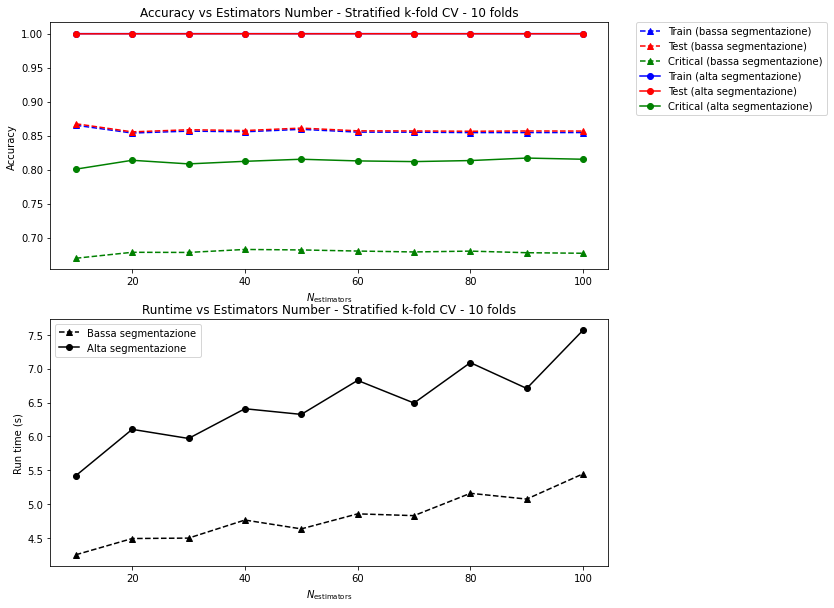

In [15]:
RFC_train_acc, RFC_cv_acc, RFC_test_acc, RFC_critical_acc = train_with_k_folds(10)
fig, axs = plot_performance(RFC_train_accuracy, RFC_test_accuracy, RFC_critical_accuracy)
axs[0].set(title="Accuracy vs Estimators Number - Stratified k-fold CV - 10 folds")
axs[1].set(title="Runtime vs Estimators Number - Stratified k-fold CV - 10 folds")
plt.show()

Com'era prevedibile, dato che già con 5 folds si aveva `train_accuracy = cv_accuracy`, tale comportamento permane anche con 10 folds. <br>
Di contro, si ha un aumento di circa 1 secondo sul runtime per ogni istanza di fit.